In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

mpl.rcParams['figure.figsize'] = (15.0, 6.0)
pd.set_option('max_columns', 30)

# Datasets Overview

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [2]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Offers

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.shape

(10, 6)

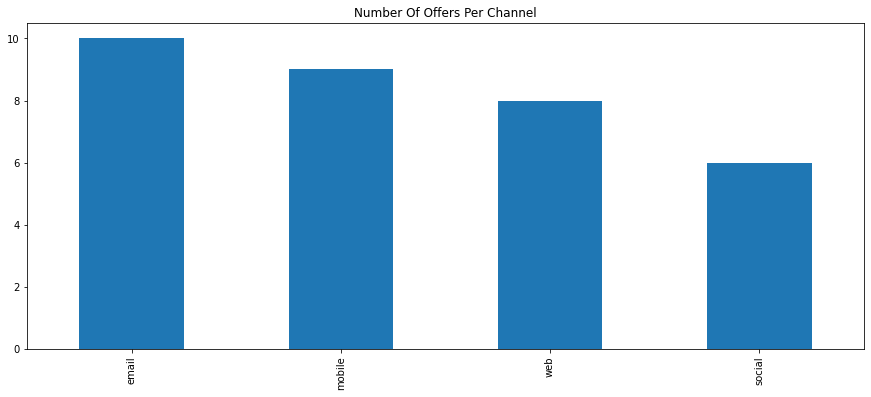

In [5]:
# Count channels
channels = portfolio.channels.explode().unique()
channel_counts = dict()
for channel in channels:
    channel_counts[channel] = portfolio.channels.str.contains(channel, regex=False).sum()
    
# Plot number of offers per channel
plt.title("Number Of Offers Per Channel")
pd.Series(channel_counts).sort_values(ascending=False).plot(kind='bar')
plt.show()

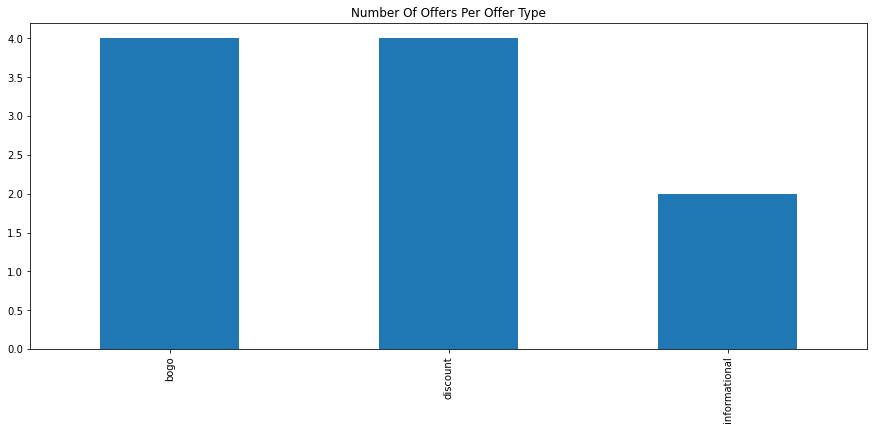

In [6]:
# Plot number of offers per offer type
plt.title("Number Of Offers Per Offer Type")
portfolio.offer_type.value_counts().plot(kind='bar')
plt.show()

## Customer

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


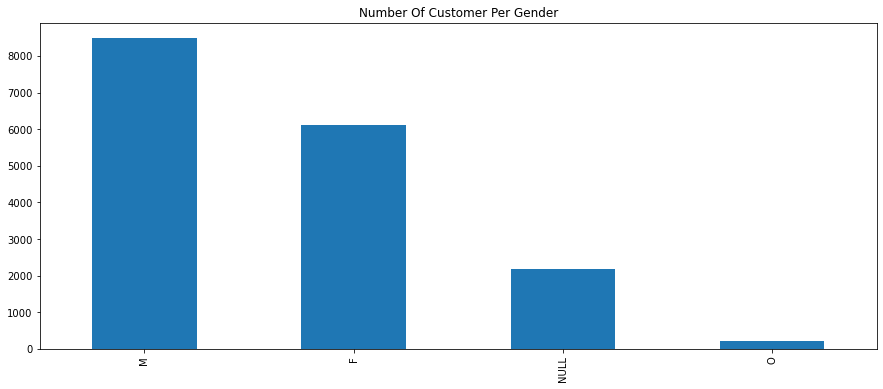

In [10]:
plt.title("Number Of Customer Per Gender")
profile.gender.fillna('NULL').value_counts().plot(kind='bar')
plt.show()

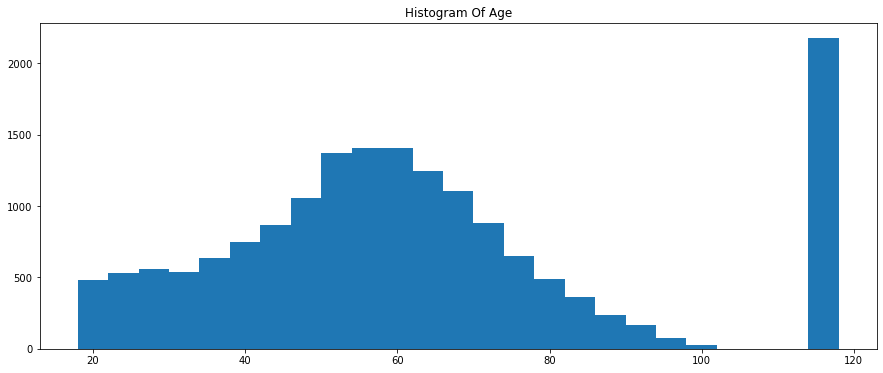

In [11]:
plt.title("Histogram Of Age")
profile.age.hist(bins=25, grid=False)
plt.show()

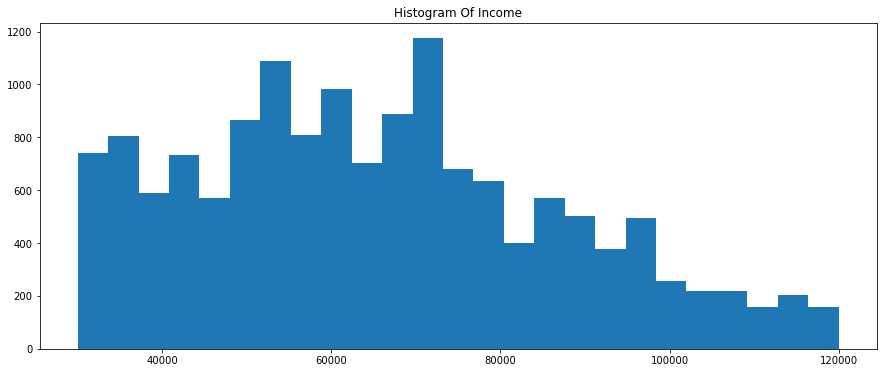

In [12]:
plt.title("Histogram Of Income")
profile.income.hist(bins=25, grid=False)
plt.show()

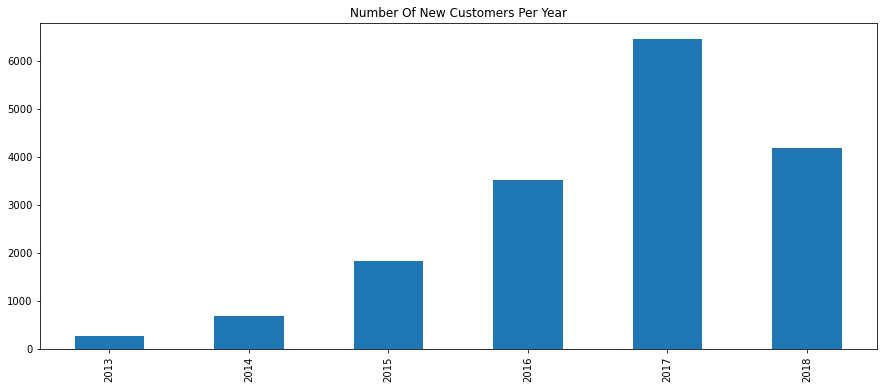

In [13]:
plt.title("Number Of New Customers Per Year")
pd.to_datetime(profile.became_member_on, format='%Y%m%d').dt.year.value_counts().sort_index().plot(kind='bar')
plt.show()

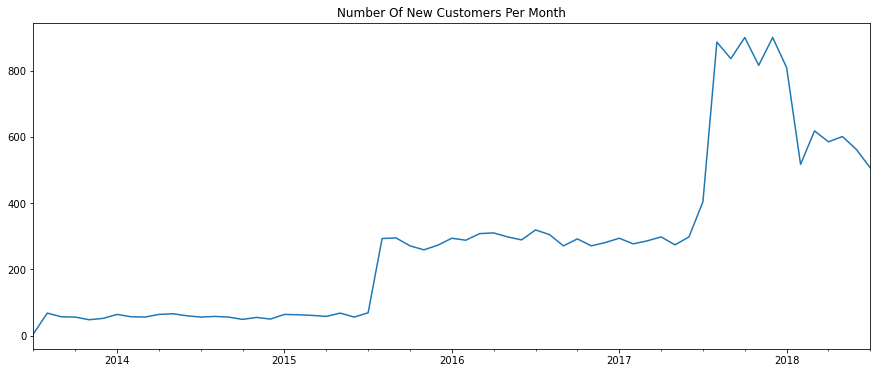

In [14]:
plt.title("Number Of New Customers Per Month")
pd.to_datetime(profile.became_member_on, format='%Y%m%d').value_counts().resample('1M').sum().sort_index().plot(kind='line')
plt.show()

## Transactions

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.shape

(306534, 4)

In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


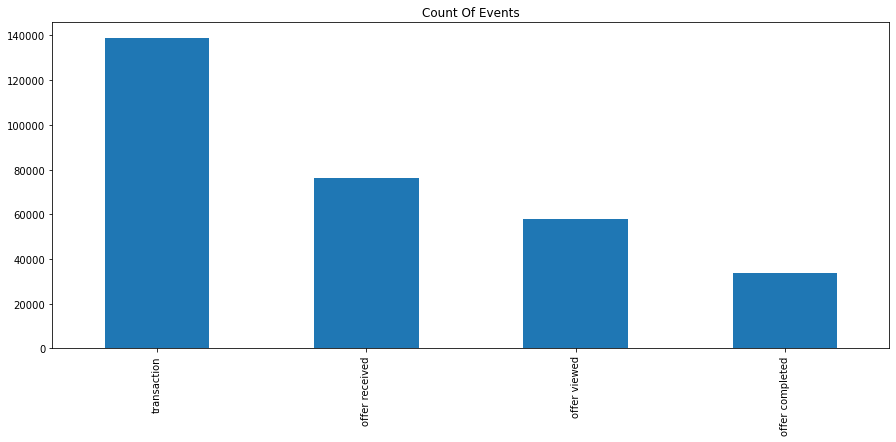

In [18]:
plt.title("Count Of Events")
transcript.event.value_counts().plot(kind='bar')
plt.show()

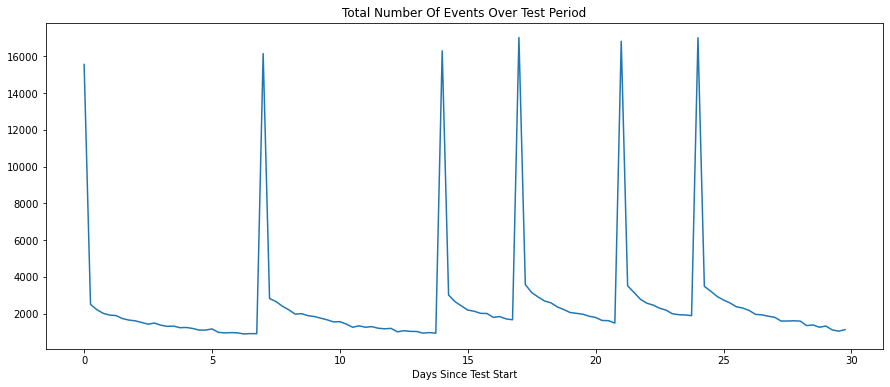

In [19]:
plt.title("Total Number Of Events Over Test Period")
(transcript.time/24).value_counts().sort_index().plot()
plt.xlabel("Days Since Test Start")
plt.show()

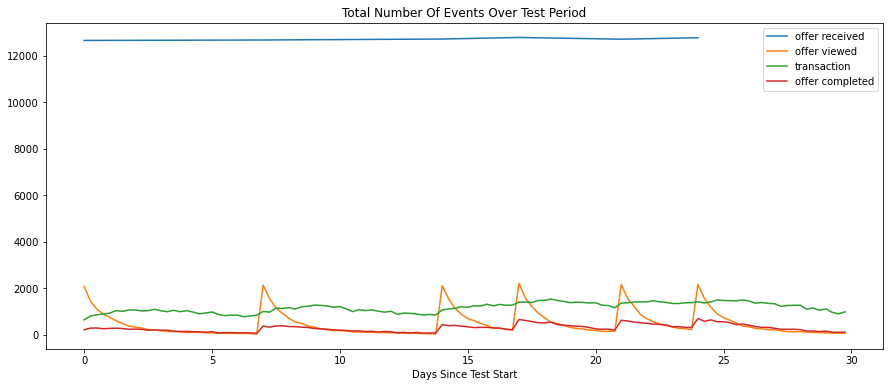

In [20]:
plt.title("Total Number Of Events Over Test Period")
for event in transcript.event.unique():
    (transcript[transcript.event==event].time/24).value_counts().sort_index().plot(label=event)
plt.xlabel("Days Since Test Start")
plt.legend()
plt.show()

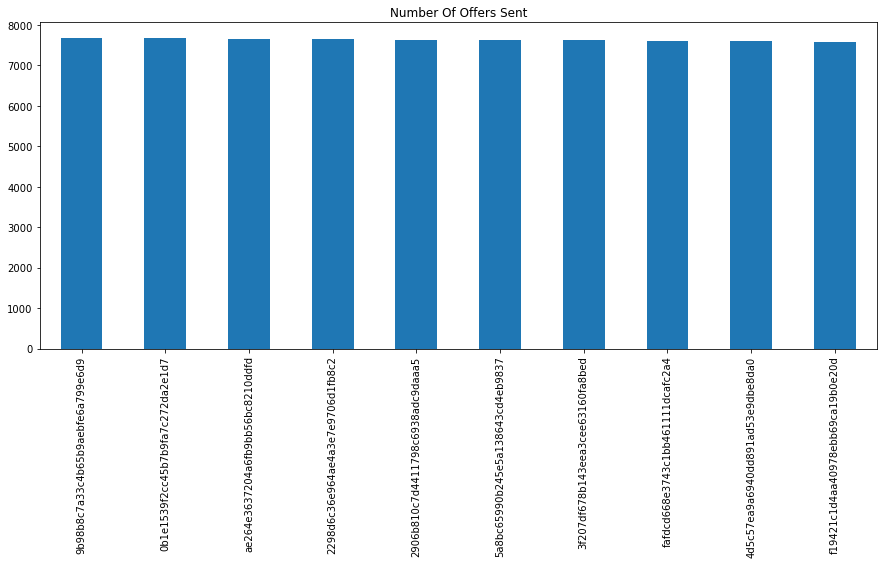

In [43]:
plt.title("Number Of Offers Sent")
transcript.loc[transcript.event=='offer received', 'value'].map(lambda x: x.get('offer id')).value_counts().plot(kind='bar')
plt.show()

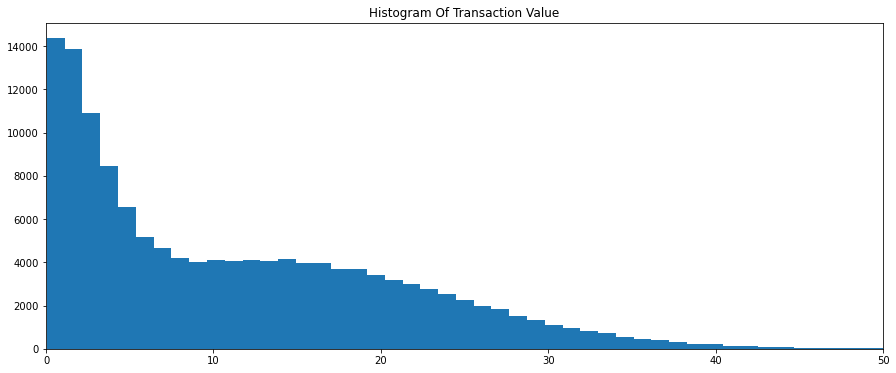

In [49]:
plt.title("Histogram Of Transaction Value")
transcript.loc[transcript.event=='transaction', 'value'].map(lambda x: x.get('amount')).hist(bins=1000, grid=False)
plt.xlim([0, 50])
plt.show()

In [21]:
transcript[transcript.person=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


# Data Processing

In [51]:
# Create target variable for each person-offer combination
offer_events = ['offer received', 'offer viewed', 'offer completed']
offers_df = transcript[transcript.event.isin(offer_events)].copy()
offers_df['offer'] = transcript.value.map(lambda x: x.get('offer id') if x.get('offer id') is not None else x.get('offer_id')) 
offers_df = offers_df[['person', 'offer', 'event']]
offers_df = (
    pd.get_dummies(offers_df, columns=['event'], prefix_sep="", prefix="") # one hot encoding of event type
    .groupby(['person', 'offer'], as_index=False).max() # check occurence of events for each person-offer combination
    .rename(columns = lambda x: x.replace(' ', '_'))
)[['person', 'offer', 'offer_viewed', 'offer_completed']]

offers_df.head()

,person,offer,offer_viewed,offer_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1


In [52]:
# Merge person and offer data
offers_df = offers_df.merge(profile, 'left', left_on='person', right_on='id').drop('id', axis=1)
offers_df = offers_df.merge(portfolio, 'left', left_on='offer', right_on='id').drop('id', axis=1)

# Drop informational offers
offers_df = offers_df[offers_df.offer_type!='informational']

# Count days since registration at the beginning at the test
# We approximate the start date of the test with the maximum registration date in the customer
# base, since the actual date is unknown
offers_df['days_since_registration'] = (
    pd.to_datetime(np.max(offers_df.became_member_on), format='%Y%m%d') 
    - pd.to_datetime(offers_df.became_member_on, format='%Y%m%d')
).dt.days
offers_df.drop('became_member_on', axis=1, inplace=True)

# One hot encode the channel column
channels = offers_df.channels.explode().unique()
for channel in channels:
    offers_df[channel] = offers_df.channels.map(lambda x: channel in x).astype(int)
offers_df.drop('channels', axis=1, inplace=True)

# Set null values in age column
offers_df['age'] = np.where(offers_df['age']==118, np.nan, offers_df['age'])

offers_df.head()

,person,offer,offer_viewed,offer_completed,gender,age,income,reward,difficulty,duration,offer_type,days_since_registration,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,M,33.0,72000.0,2,10,7,discount,461,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,M,33.0,72000.0,5,5,5,bogo,461,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,M,33.0,72000.0,2,10,10,discount,461,1,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0,None,NaN,NaN,5,5,5,bogo,92,1,1,1,1
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,O,40.0,57000.0,5,20,10,discount,198,1,1,0,0


# Data Exploration

## View Rate Of Offers 

In [53]:
offers_df.offer_viewed.mean()

0.7864999901257973

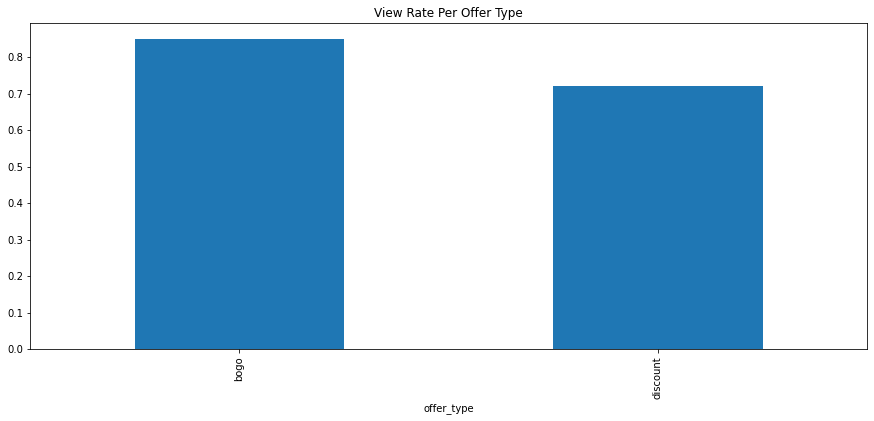

In [54]:
plt.title("View Rate Per Offer Type")
offers_df.groupby('offer_type').offer_viewed.mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

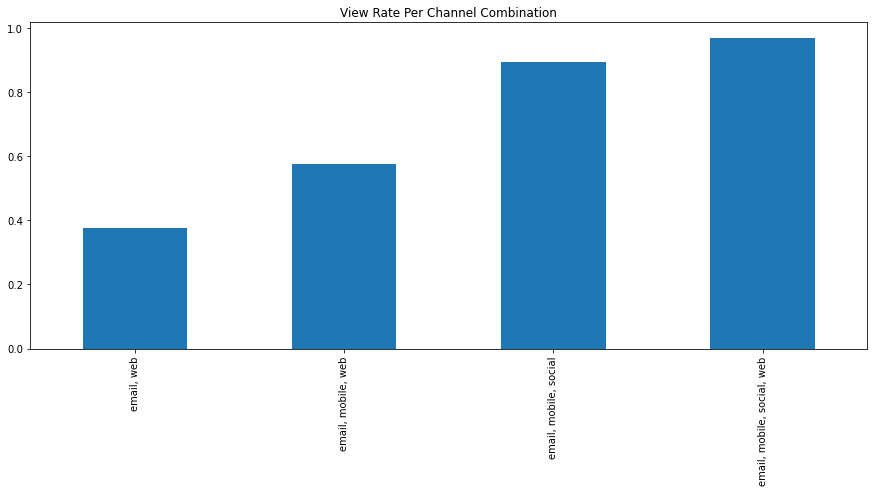

In [55]:
plt.title("View Rate Per Channel Combination")
channel_views = offers_df.groupby(['web', 'email', 'mobile', 'social']).offer_viewed.mean()
channel_views.index = channel_views.index.map(
    lambda x: ", ".join(
        sorted(
            [channel_views.index.names[i] for i in range(len(channel_views.index.names)) if x[i]]
        )
    )
)
channel_views.sort_index(key=lambda x: x.str.len()).plot(kind='bar')
plt.show()

In [56]:
# Remove offers that have not been seen
offers_df = offers_df[offers_df.offer_viewed==1].drop('offer_viewed', axis=1)

## Overview Of Columns

In [57]:
offers_df.shape

(39826, 15)

In [58]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39826 entries, 3 to 63287
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   person                   39826 non-null  object 
 1   offer                    39826 non-null  object 
 2   offer_completed          39826 non-null  uint8  
 3   gender                   34451 non-null  object 
 4   age                      34451 non-null  float64
 5   income                   34451 non-null  float64
 6   reward                   39826 non-null  int64  
 7   difficulty               39826 non-null  int64  
 8   duration                 39826 non-null  int64  
 9   offer_type               39826 non-null  object 
 10  days_since_registration  39826 non-null  int64  
 11  web                      39826 non-null  int32  
 12  email                    39826 non-null  int32  
 13  mobile                   39826 non-null  int32  
 14  social                

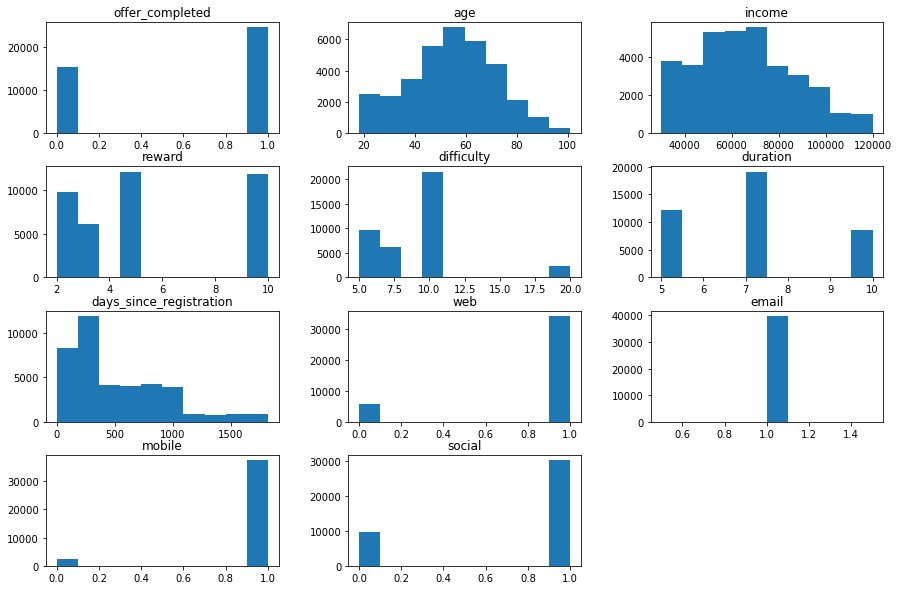

In [59]:
offers_df.hist(figsize=(15, 10), grid=False)
plt.show()

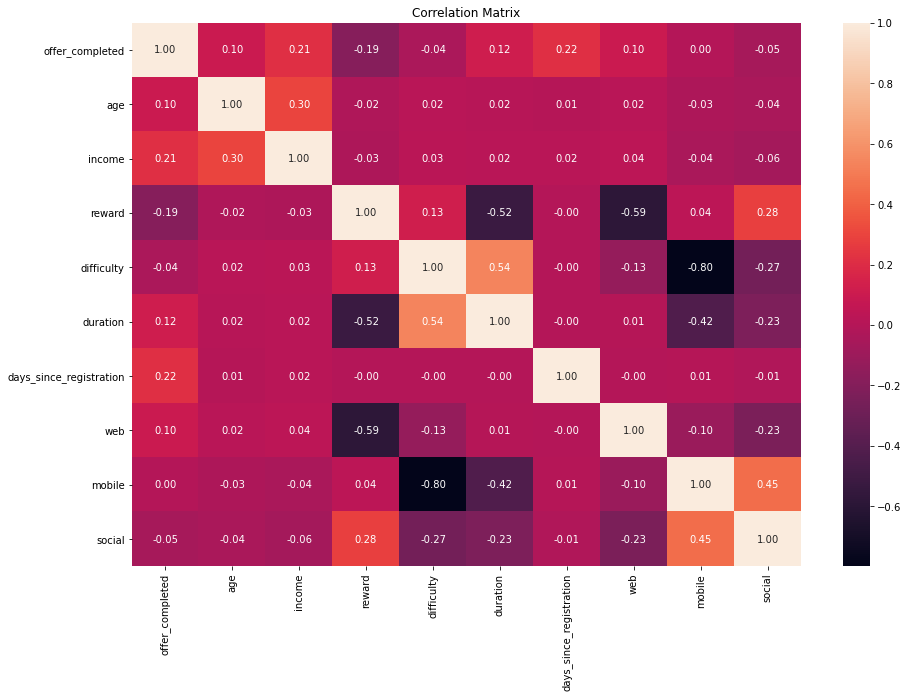

In [60]:
plt.figure(figsize=(15, 10))
plt.title("Correlation Matrix")
sns.heatmap(offers_df.drop('email', axis=1).corr(), annot=True, fmt='.2f')
plt.show()

## Completion Rate Per Offer

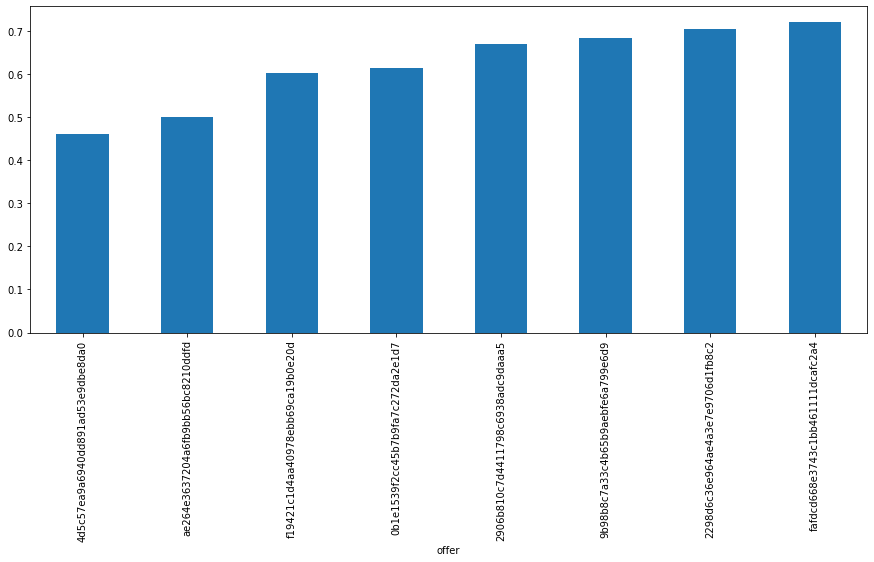

In [61]:
plt.figure("Completion Rate Per Offer")
offers_df.groupby('offer').offer_completed.mean().sort_values().plot(kind='bar')
plt.show()

## Relationship Between Features And Target

#### Offer Related Features

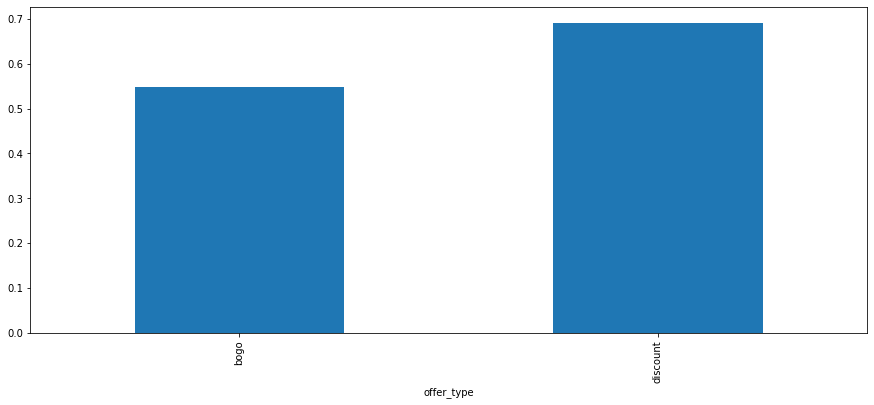

In [62]:
plt.figure("Completion Rate Per Offer Type")
offers_df.groupby('offer_type').offer_completed.mean().sort_values().plot(kind='bar')
plt.show()

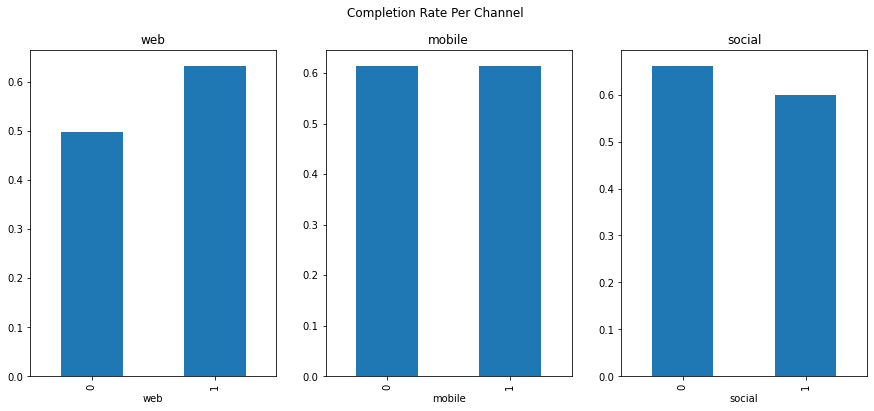

In [80]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Completion Rate Per Channel")
channels = ['web', 'mobile', 'social']
for ax, channel in zip(axes, channels):
    ax.set_title(channel)
    offers_df.groupby(channel).offer_completed.mean().sort_index().plot(kind='bar', ax=ax)
plt.show()

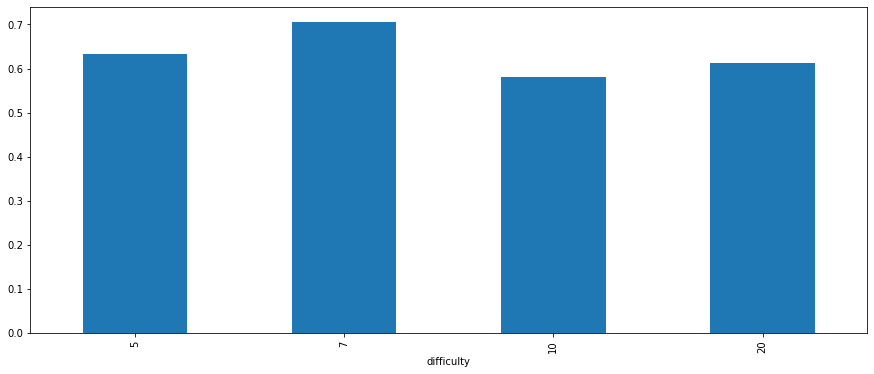

In [87]:
plt.figure("Completion Rate Per Difficulty")
offers_df.groupby('difficulty').offer_completed.mean().sort_index().plot(kind='bar')
plt.show()

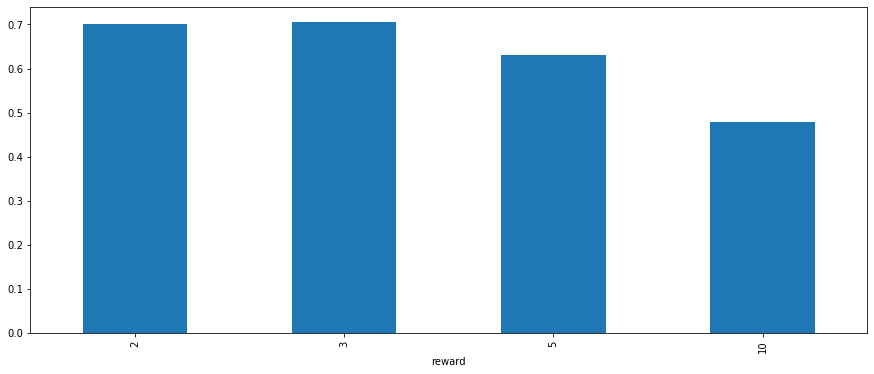

In [88]:
plt.figure("Completion Rate Per Reward")
offers_df.groupby('reward').offer_completed.mean().sort_index().plot(kind='bar')
plt.show()

#### Customer-Related Features